# Post Process Lidar

In this notebook im going to up attempt to interpret missing boxes from large datasets
for example missing boxes in the 100m data will be interpreted as having the same results
as the 1000m box they fall inside and then the same will be done to the 10m

Imagine a bad cop drama with "the computer expert" saying enhancing repeatedly, and basically that

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("starting...")

[2025-04-02 11:49:08.471656] starting...


In [3]:
resolutions = sorted([1000,100,10], reverse=True)
lp(f"Resolutions:  {resolutions}")
outPath = f"{os.path.curdir}{os.sep}output{os.sep}"
lp(f"outPath: {outPath}")
files = {r:f"{outPath}AggregateLidarData_{r}m.parquet" for r in resolutions}

[2025-04-02 11:49:08.478947] Resolutions:  [1000, 100, 10]
[2025-04-02 11:49:08.479682] outPath: ./output/


In [4]:
lp(f"Loading files:  {files}")
startTime = datetime.now()
datas = {r:gpd.read_parquet(files[r]) for r in resolutions}
lp(f"All files loaded in {datetime.now()-startTime}")

[2025-04-02 11:49:08.484729] Loading files:  {1000: './output/AggregateLidarData_1000m.parquet', 100: './output/AggregateLidarData_100m.parquet', 10: './output/AggregateLidarData_10m.parquet'}
[2025-04-02 11:49:14.090729] All files loaded in 0:00:05.605846


In [5]:
datas[1000].head(2)

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",3.124952e+09,845.0,1.218623e+09,1588830.0,0 days 00:00:01.036888
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",6.639287e+09,911.0,1.180152e+09,1289143.0,0 days 00:00:02.412734


In [6]:
for key in datas.keys():
    lp(f"Processing aggregate columns for {key}m resolution")
    for col in ['AltitudeTotal','WaterTotal','Int', 'Total']:
        datas[key][col] = datas[key][col].astype(pd.Int64Dtype())
        
    datas[key]['MeanAltitude'] = datas[key]['AltitudeTotal'] / datas[key]['Total'] * (0.001 * 3.28084)  #multiple by scale and convert meters 2 feet
    datas[key]['MeanIntensity'] = (np.round(datas[key]['Int'] / datas[key]['Total'])).astype(pd.Int64Dtype())
    datas[key]['PercentWater'] = datas[key]['WaterTotal'] / datas[key]['Total'] * 100.0
    datas[key]['IsInterpolated'] = False


[2025-04-02 11:49:14.113454] Processing aggregate columns for 1000m resolution
[2025-04-02 11:49:14.119430] Processing aggregate columns for 100m resolution
[2025-04-02 11:49:14.149533] Processing aggregate columns for 10m resolution


In [7]:
datas[1000].dtypes

geometry                 geometry
AltitudeTotal               Int64
WaterTotal                  Int64
Int                         Int64
Total                       Int64
RunTime           timedelta64[us]
MeanAltitude              Float64
MeanIntensity               Int64
PercentWater              Float64
IsInterpolated               bool
dtype: object

In [8]:
datas[1000].head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater,IsInterpolated
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",3124952105,845,1218623103,1588830,0 days 00:00:01.036888,6.452841,767,0.053184,False
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",6639286643,911,1180151691,1289143,0 days 00:00:02.412734,16.896835,915,0.070667,False
6,"POLYGON ((777039 3313888, 777039 3314888, 7760...",4592979709,7657,955301611,1359746,0 days 00:00:02.444807,11.082093,703,0.56312,False
7,"POLYGON ((777039 3314888, 777039 3315888, 7760...",3447445693,1599,730120809,1165901,0 days 00:00:03.211889,9.701096,626,0.137147,False
8,"POLYGON ((777039 3315888, 777039 3316888, 7760...",3901735825,2183,866172352,1620405,0 days 00:00:03.265591,7.899859,535,0.134719,False


<Axes: >

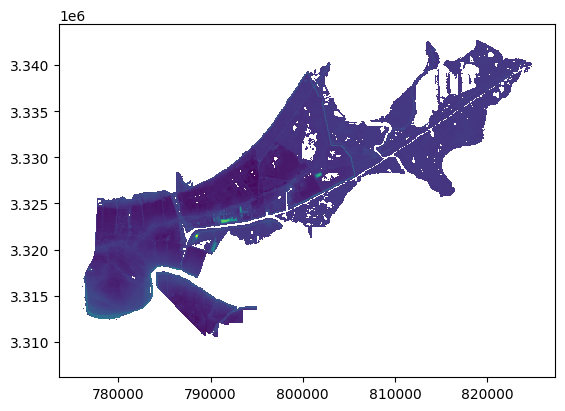

In [9]:
datas[100].plot(column='MeanAltitude')

In [10]:
for r in resolutions:
    totalMissing = np.count_nonzero( datas[r]['Total'] == 0 )
    percentMissing = totalMissing / datas[r].shape[0] * 100.0
    lp( f"For {r}m missing\t{totalMissing}/{datas[r].shape[0]}  ({round(percentMissing,1)}%)")

[2025-04-02 11:49:20.788409] For 1000m missing	35/648  (5.4%)
[2025-04-02 11:49:20.789965] For 100m missing	8067/55104  (14.6%)
[2025-04-02 11:49:20.797757] For 10m missing	1359996/5394495  (25.2%)


In [11]:
def process(lowRes, highRes, columns=['MeanAltitude', 'MeanIntensity', 'PercentWater']):
    startTime = datetime.now()
    output = lowRes.copy()

    for idx, box in highRes[~pd.isna(highRes['MeanAltitude'])].iterrows():
        
        mask = np.logical_and(output.intersects( box['geometry'] ), output['Total']==0)
        output.loc[mask,'IsInterpolated'] = True
        for col in columns: 
            output.loc[mask,col] = box[col]

    lp(f"{np.count_nonzero(output['IsInterpolated'])} processed in {datetime.now()-startTime}")
    return output

outputs = {}
outputs[1000] = datas[1000]
lp("Processing 100m output")
outputs[100] = process(datas[100], datas[1000])

[2025-04-02 11:49:20.806759] Processing 100m output
[2025-04-02 11:49:23.750606] 8067 processed in 0:00:02.943554


In [12]:
outputs[100].head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater,IsInterpolated
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0,0,0,0,0 days 00:00:00.228102,9.701096,626,0.137147,True
77,"POLYGON ((776139 3315588, 776139 3315688, 7760...",0,0,0,0,0 days 00:00:00.200766,9.701096,626,0.137147,True
78,"POLYGON ((776139 3315688, 776139 3315788, 7760...",0,0,0,0,0 days 00:00:00.198523,9.701096,626,0.137147,True
79,"POLYGON ((776139 3315788, 776139 3315888, 7760...",0,0,0,0,0 days 00:00:00.181250,7.899859,535,0.134719,True
80,"POLYGON ((776139 3315888, 776139 3315988, 7760...",0,0,0,0,0 days 00:00:00.190977,7.899859,535,0.134719,True


In [13]:
lp("Processing 10m  output")
outputs[10] = process(datas[10], outputs[100])

[2025-04-02 11:49:23.768314] Processing 10m  output
[2025-04-02 15:50:28.581848] 1158321 processed in 4:01:04.813373


In [14]:
outputs[10].head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater,IsInterpolated
845.0,"POLYGON ((776049 3316338, 776049 3316348, 7760...",0,0,0,0,0 days 00:00:01.203105,7.899859,535,0.134719,True
846.0,"POLYGON ((776049 3316348, 776049 3316358, 7760...",0,0,0,0,0 days 00:00:01.202179,7.899859,535,0.134719,True
847.0,"POLYGON ((776049 3316358, 776049 3316368, 7760...",0,0,0,0,0 days 00:00:01.199199,7.899859,535,0.134719,True
848.0,"POLYGON ((776049 3316368, 776049 3316378, 7760...",0,0,0,0,0 days 00:00:01.223570,7.899859,535,0.134719,True
849.0,"POLYGON ((776049 3316378, 776049 3316388, 7760...",0,0,0,0,0 days 00:00:01.194712,7.899859,535,0.134719,True


In [15]:
outFiles = []
for r in resolutions:
    outFile = f"{outPath}PostProcessedLidat_{r}m.parquet"
    outFiles.append(outFile)
    lp(f"Saving resolution {r} to {outFile}")
    outputs[r].to_parquet(outFile)

[2025-04-02 15:50:28.601090] Saving resolution 1000 to ./output/PostProcessedLidat_1000m.parquet
[2025-04-02 15:50:28.608243] Saving resolution 100 to ./output/PostProcessedLidat_100m.parquet
[2025-04-02 15:50:28.697830] Saving resolution 10 to ./output/PostProcessedLidat_10m.parquet


In [16]:
for file in outFiles:
    !aws s3 cp $file s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/

upload: output/PostProcessedLidat_1000m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/PostProcessedLidat_1000m.parquet
upload: output/PostProcessedLidat_100m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/PostProcessedLidat_100m.parquet
upload: output/PostProcessedLidat_10m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/PostProcessedLidat_10m.parquet


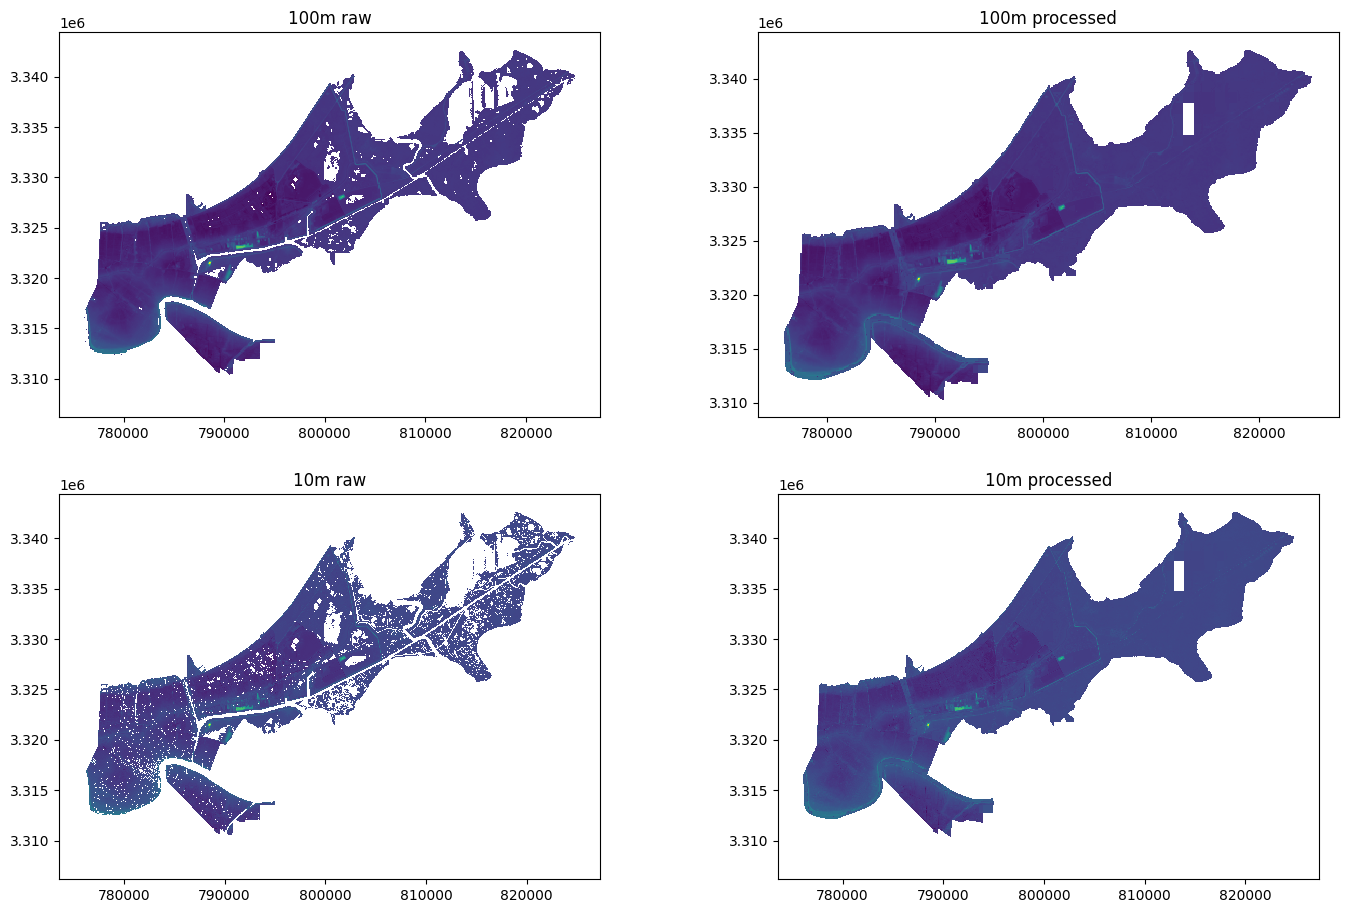

In [17]:
fig,axs = plt.subplots(figsize=(17,11), nrows=2,ncols=2)

for r,row in zip(resolutions[1:],axs):
    row[0].set_title(f"{r}m raw")
    row[1].set_title(f"{r}m processed")
    datas[r].plot(ax=row[0], column='MeanAltitude')
    outputs[r].plot(ax=row[1],column='MeanAltitude')


In [18]:
lp("Done!")

[2025-04-02 16:13:25.004908] Done!
